K-평균 군집화
=======

K-평균 군집화 소개
---------------

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

k-평균 알고리즘은 레이블이 없는 다차원 데이터세트 내에 사전 정의된 군집의 개수를 찾아낸다.  
이 때 최적의 군집화는 다음과 같다는 개념을 사용한다  

**'군집 중앙'은 해당 군집에 속하는 모든 점의 산술 평균이다**  
**각 점은 다른 군집의 중앙보다 자신이 속한 군집의 중앙에 더 가깝다**  

우선 뚜렷이 구분되는 4개의 영역을 포함하는 2차원 데이터세트를 생성하자.  
이것이 비지도 알고리즘이라는 사실을 강조하기 위해 시각화에 레이블은 제외할 것이다.  

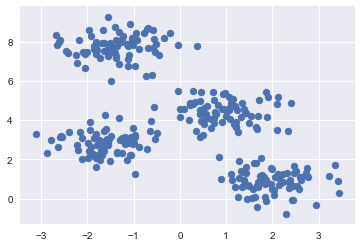

In [4]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 300, centers = 4,
                      cluster_std = 0.60, random_state = 0)
plt.scatter(X[:, 0], X[:, 1], s = 50)

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

K-평균 알고리즘은 기댓값-최대화(E-M) 방식으로 구현된다  
1. 일부 군집 중심을 추측한다
2. 수렴될 때까지 다음을 반복한다.  
E-단계 : 점을 가장 가까운 군집 중심에 할당한다  
M-단계 : 군집 중심을 평균값에 설정한다  

**k-평균 알고리즘 구현**

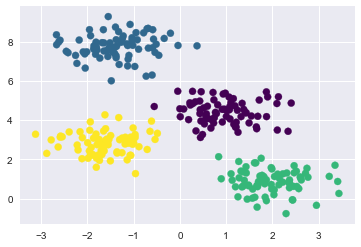

In [9]:
from sklearn.metrics import pairwise_distances_argmin

def find_cluster(X, n_clusters, rseed = 2):
    # 1. 임의의 군집 선택
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a : 가장 가까운 중심을 기반으로 레이블 할당
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b : 점들의 평균으로부터 새로운 군집 발견
        new_centers = np.array([X[labels == i].mean(0)
                               for i in range(n_clusters)])
        
        # 2c : 수렴 여부 검사
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
    return centers, labels

centers, labels = find_cluster(X, 4)
plt.scatter(X[:, 0], X[:, 1], c = labels,
           s = 50, cmap = 'viridis')

기댓값-최대화 관련 주의사항
----------------

**1. 전체적으로 최적화된 결과를 얻을 수 없을지도 모른다**   
간단한 절차에 다른 난수 초기값을 사용하면 그 특정 초기 추측값으로 인해 만족스럽지 않은 결과를 얻을 수 있다.  

**2. 군집의 개수가 사전에 정해져야 한다**  

**3. k-평균 은 선형 군집 경계로 한정된다**  

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise = .05, random_state = 0)

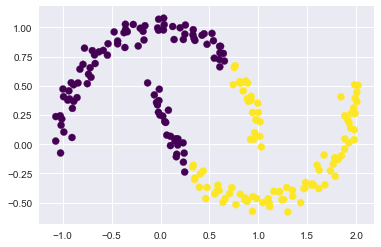

In [16]:
# 실패한 k-평균 알고리즘
labels = KMeans(2, random_state = 0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels,
           s = 50, cmap = 'viridis')

SpectralClustering 추정기는 데이터의 고차원 표현을 계산하기 위해 최근접 이웃의 그래프를  
사용하고, k-평균 알고리즘을 사용해 레이블을 할당한다.  

C:\Users\default.DESKTOP-S5Q9GAA\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


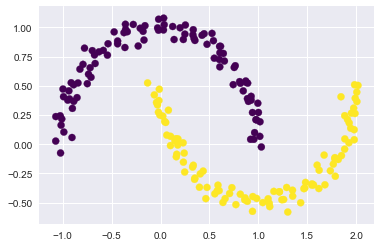

In [17]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters = 2,
                          affinity = 'nearest_neighbors',
                          assign_labels = 'kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels,
           s = 50, cmap = 'viridis')

**4. k- 평균은 표본 수가 많을 때 느려질 수 있다**

예제1 : 숫자 데이터에 k-평균 알고리즘 사용하기
    -----------------------

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [19]:
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

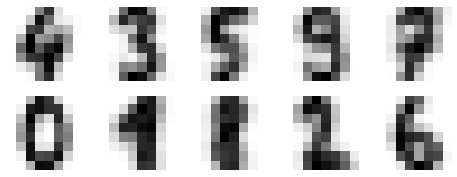

In [20]:
fig, ax = plt.subplots(2, 5, figsize = (8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks = [], yticks = [])
    axi.imshow(center, interpolation = 'nearest', cmap = plt.cm.binary)

결과를 통해 KMeans가 레이블 없이도 1과 8을 제외하면 인식 가능한 숫자를 중심으로  
갖는 군집을 구할 수 있다는 사실을 알 수 있다.  

k-평균 군집의 정체에 대해 아무 것도 모르기 때문에 0-9까지 레이블은 바뀔 수 있다.  
이 문제는 각 학습된 군집 레이블을 그 군집 내에서 발견된 실제 레이블과 매칭해 봄으로써 해결할 수 있다.  

In [23]:
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

간단한 k-평균 알고리즘만으로도 입력 숫자 데이터의 80%를 올바르게 분류할 수 있다  
이에 대한 오차 행렬을 확인해보자  

Text(92.68,0.5,'predicted label')

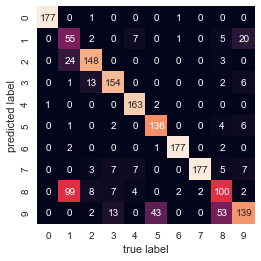

In [27]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
           xticklabels = digits.target_names,
           yticklabels = digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

앞에서 시각화한 군집 중심으로부터 예상할 수 있듯이 오차의 주요 지점은 8과 1에 있다  
그러나 이것도 여전히 k-평균을 사용하면 알려진 레이블을 참조하지 않고도 근본적으로  
숫자 분류기를 구축할 수 있음을 보여 준다.   

k-평균을 수행하기 전에 데이터를 전처리하는 데 t-분포 확률 이웃 임베딩 알고리즘을 사용할 수 있다.  
t-SNE는 특히 군집 내의 점을 보존하는 데 능숙한 비선형 임베딩 알고리즘이다.  

In [28]:
from sklearn.manifold import TSNE
# 데이터 사영 : 이 단계는 수 초가 걸린다
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
digits_proj = tsne.fit_transform(digits.data)

# 군집 계산
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits_proj)

# 레이블 바꾸기
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
# 정확도 계산
accuracy_score(digits.target, labels)

0.9371174179187535

예제2 : 색상 압축에 k-평균 사용하기
    -----------------

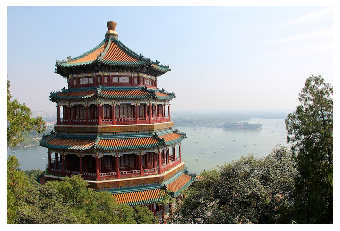

In [30]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
ax = plt.axes(xticks = [], yticks = [])
ax.imshow(china)

In [31]:
china.shape

(427, 640, 3)

이미지 자체는 크기가 (height, width, RGB)인 3차원 배열에 저장되며,  
여기서 RGB 기여도는 0부터 255까지의 정수로 나타낸다  

데이터를 [n_samples, x n_features]로 형태를 재구성하고  
색상이 0에서 1사이에 놓일 수 있도록 척도록 척도를 바꿔보자  

In [33]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

효율성을 위해 픽셀 10,000개의 부분집합을 사용해 이 색 공간에서 이 픽셀을 시각화할 수 있다.  

In [38]:
def plot_pixels(data, title, colors = None, N = 10000):
    if colors is None:
        colors = data
    # 임의의 부분 집합 선택
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    ax[0].scatter(R, G, color = colors, marker = '.')
    ax[0].set(xlabel = 'Red', ylabel = 'Green', xlim = (0, 1), ylim = (0, 1))
    
    ax[1].scatter(R, G, color = colors, marker = '.')
    ax[1].set(xlabel = 'Red', ylabel = 'Green', xlim = (0, 1), ylim = (0, 1))
    fig.suptitle(title, size = 20)

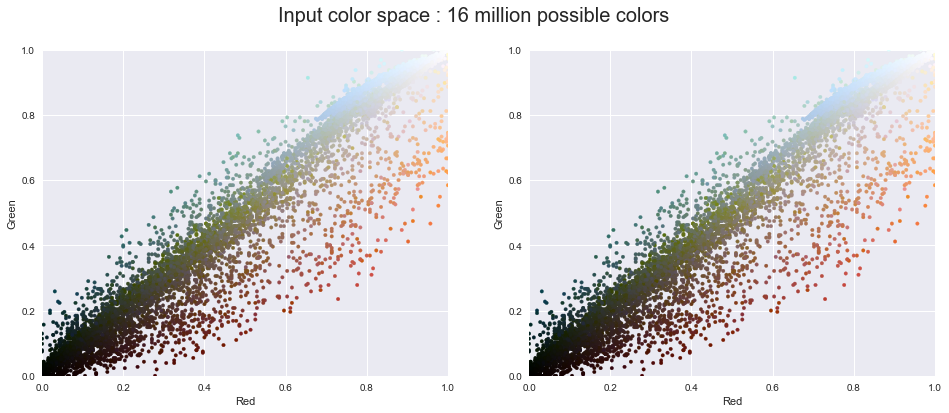

In [39]:
plot_pixels(data, title = 'Input color space : 16 million possible colors')

이제 픽셀 공간에서 k-평균 군집화를 사용해 이 1600만 가지 색을 16개의 색으로 줄이자  
이를 위해 데이터의 부분 집합에 대해 연산을 수행 하는 미니 배치 k-평균을 사용할 것이다  

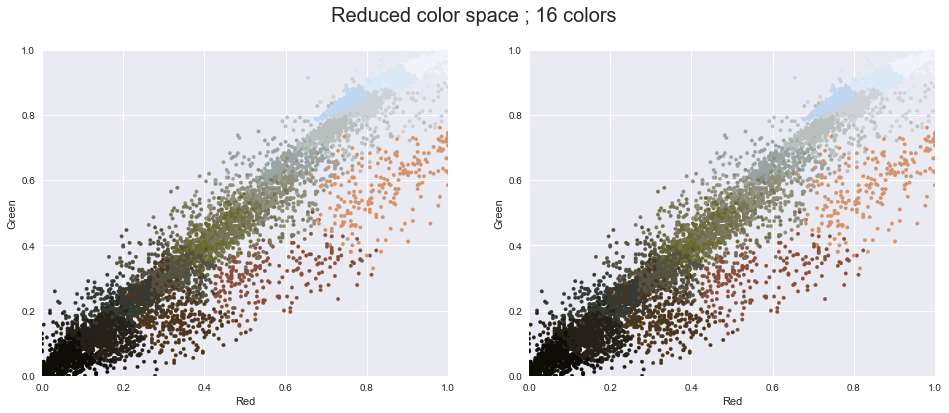

In [40]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors = new_colors,
           title = 'Reduced color space ; 16 colors')

Text(0.5,1,'16 color Image')

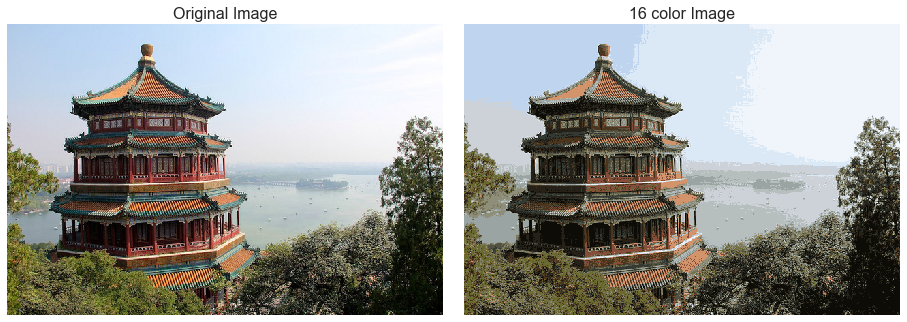

In [41]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize = (16, 6),
                      subplot_kw = dict(xticks = [], yticks = []))
fig.subplots_adjust(wspace = 0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size = 16)
ax[1].imshow(china_recolored)
ax[1].set_title('16 color Image', size = 16)